# AN2DL - First Challenge

_Lorenzo Bardelli, Lorenzo Moretti, Luca Zani_

`thegradientdescenders`

In [ ]:
# Set seed for reproducibility
SEED = 69

# Standard library imports
import os
import sys
import math
import random
import warnings
from scipy import stats

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Numerical and data processing
import numpy as np
import pandas as pd

# Set seeds for random number generators
np.random.seed(SEED)
random.seed(SEED)

# PyTorch
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter # Added this line

torch.manual_seed(SEED)

# Scikit-learn
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Setup logging and directories
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

# Setup PyTorch device
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Configure plot display settings
sns.set_theme(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

# Environment detection and directory setup
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount("/gdrive")
    current_dir = "/gdrive/My\ Drive/Colab\ Notebooks/ANNDL"
    %cd $current_dir
else:
    current_dir = os.path.dirname(os.path.abspath("__file__")) if "__file__" in globals() else os.getcwd()
    dataset_dir = os.path.join(current_dir, "dataset")

<>:70: SyntaxWarning: invalid escape sequence '\ '
<>:70: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipython-input-2963961082.py:70: SyntaxWarning: invalid escape sequence '\ '
  current_dir = "/gdrive/My\ Drive/Colab\ Notebooks/ANNDL"


PyTorch version: 2.8.0+cu126
Device: cuda
Mounted at /gdrive
/gdrive/My Drive/Colab Notebooks/ANNDL


In [ ]:
# Set path to local dataset folder
if IN_COLAB:
    os.environ["DATASET_NAME"] = "pirate_pain_train.csv"
    os.environ["DATASET_URL"] = "1qiKAdJ22NnBMQzIyos_efP2Yxgkvqq8O"

    # Check if dataset exists, download and unzip if not
    if not os.path.exists(os.environ["DATASET_NAME"]):
        print("Downloading pirate pain dataset...")
        !gdown -q ${DATASET_URL} -O ${DATASET_NAME}
        print("Pirate pain dataset downloaded!")
    else:
        print("Pirate pain dataset already downloaded. Using cached data.")

    dataset = pd.read_csv('pirate_pain_train.csv')
    dataset_labels = pd.read_csv('pirate_pain_train_labels.csv')
else:
    train_csv_path = os.path.join(dataset_dir, "pirate_pain_train.csv")
    train_labels_path = os.path.join(dataset_dir, "pirate_pain_train_labels.csv")
    test_csv_path = os.path.join(dataset_dir, "pirate_pain_test.csv")
    sample_submission_path = os.path.join(dataset_dir, "sample_submission.csv")

    # Check if dataset files exist
    if os.path.exists(train_csv_path):
        print("Pirate pain dataset found in local folder!")
    else:
        print("Dataset not found! Please ensure the dataset folder contains the CSV files.")

    dataset = pd.read_csv('dataset/pirate_pain_train.csv')
    dataset_labels = pd.read_csv('dataset/pirate_pain_train_labels.csv')

# Print the shape of the dataset
print(f"Dataset shape: {dataset.shape}")
print(f"Dataset labels shape: {dataset_labels.shape}")

# Display the first few rows of the dataset
dataset.head()

Pirate pain dataset already downloaded. Using cached data.
Dataset shape: (105760, 40)
Dataset labels shape: (661, 2)


,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30
0,0,0,2,0,2,1,two,two,two,1.094705,...,3.499558e-06,1.945042e-06,0.000004,1.153299e-05,0.000004,0.017592,0.013508,0.026798,0.027815,0.5
1,0,1,2,2,2,2,two,two,two,1.135183,...,3.976952e-07,6.765107e-07,0.000006,4.643774e-08,0.000000,0.013352,0.000000,0.013377,0.013716,0.5
2,0,2,2,0,2,2,two,two,two,1.080745,...,1.533820e-07,1.698525e-07,0.000001,2.424536e-06,0.000003,0.016225,0.008110,0.024097,0.023105,0.5
3,0,3,2,2,2,2,two,two,two,0.938017,...,1.006865e-05,5.511079e-07,0.000002,5.432416e-08,0.000000,0.011832,0.007450,0.028613,0.024648,0.5
4,0,4,2,2,2,2,two,two,two,1.090185,...,4.437266e-06,1.735459e-07,0.000002,5.825366e-08,0.000007,0.005360,0.002532,0.033026,0.025328,0.5


## Data Preprocessing

In [4]:
def preprocess_stringed_num(value):
    if isinstance(value, pd.Series):
        return value.apply(preprocess_stringed_num)
    if value == 1 or value == "one+peg_leg" or value == "one+hook_hand" or value == "one+eye_patch":
        return np.int8(1)
    elif value == 2 or value == "two":
        return np.int8(2)
    raise ValueError(f"Unexpected value: {value}")

# Convert columns to numeric values
dataset['n_legs'] = preprocess_stringed_num(dataset['n_legs'])
dataset['n_hands'] = preprocess_stringed_num(dataset['n_hands'])
dataset['n_eyes'] = preprocess_stringed_num(dataset['n_eyes'])

# Get unique user IDs and shuffle them
unique_users = dataset['sample_index'].unique()
random.seed(SEED) # Ensure reproducibility of shuffling
random.shuffle(unique_users)

# Define the number of users for validation and test sets we use 80 10 10 split
N_VAL_USERS = int(0.1 * len(unique_users))
N_TEST_USERS = int(0.1 * len(unique_users))

# Calculate the number of users for the training set
n_train_users = len(unique_users) - N_VAL_USERS - N_TEST_USERS

# Split the shuffled user IDs into training, validation, and test sets
train_users = unique_users[:n_train_users]
val_users = unique_users[n_train_users:n_train_users + N_VAL_USERS]
test_users = unique_users[n_train_users + N_VAL_USERS:]

# Split the dataset into training, validation, and test sets based on user IDs
df_train = dataset[dataset['sample_index'].isin(train_users)]
df_val = dataset[dataset['sample_index'].isin(val_users)]
df_test = dataset[dataset['sample_index'].isin(test_users)]

# Print the shapes of the split datasets
print(f"Train set shape: {df_train.shape}")
print(f"Validation set shape: {df_val.shape}")
print(f"Test set shape: {df_test.shape}")

Train set shape: (84640, 40)
Validation set shape: (10560, 40)
Test set shape: (10560, 40)



Label Distribution Across Splits:
           Training  Validation  Test
no_pain         402          53    56
low_pain         78           9     7
high_pain        49           4     3

Percentages:
           Training  Validation   Test
no_pain       75.99       80.30  84.85
low_pain      14.74       13.64  10.61
high_pain      9.26        6.06   4.55


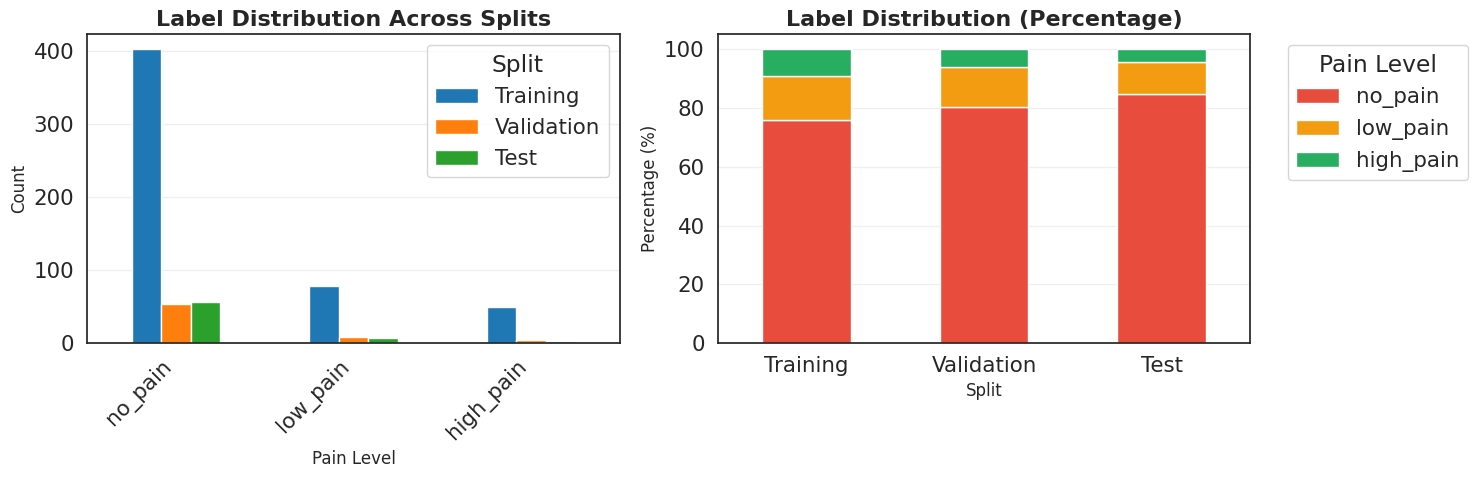

In [ ]:
# Label distribution

def get_label_distribution(df, dataset_labels):
    """Count label distribution for a given dataframe using pandas operations."""
    # Get unique sample indices from the dataframe
    sample_indices = df['sample_index'].unique()

    # Filter labels for these samples and count occurrences
    labels = dataset_labels[dataset_labels['sample_index'].isin(sample_indices)]
    distribution = labels['label'].value_counts().to_dict()

    # Ensure all categories are present (even if count is 0)
    for label in ['no_pain', 'low_pain', 'high_pain']:
        distribution.setdefault(label, 0)

    return distribution

# Calculate distributions for all sets
training_labels = get_label_distribution(df_train, dataset_labels)
validation_labels = get_label_distribution(df_val, dataset_labels)
test_labels = get_label_distribution(df_test, dataset_labels)

# Create a summary dataframe for better visualization
distribution_df = pd.DataFrame({
    'Training': training_labels,
    'Validation': validation_labels,
    'Test': test_labels
})

# Display the distribution table
print("\nLabel Distribution Across Splits:")
print("=" * 50)
print(distribution_df)
print("\nPercentages:")
print((distribution_df / distribution_df.sum() * 100).round(2))

# Visualize the distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Bar plot
distribution_df.plot(kind='bar', ax=axes[0], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
axes[0].set_title('Label Distribution Across Splits', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Pain Level', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].legend(title='Split')
axes[0].grid(axis='y', alpha=0.3)
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45, ha='right')

# Stacked percentage plot
distribution_pct = distribution_df / distribution_df.sum() * 100
distribution_pct.T.plot(kind='bar', stacked=True, ax=axes[1],
                         color=['#e74c3c', '#f39c12', '#27ae60'])
axes[1].set_title('Label Distribution (Percentage)', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Split', fontsize=12)
axes[1].set_ylabel('Percentage (%)', fontsize=12)
axes[1].legend(title='Pain Level', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].grid(axis='y', alpha=0.3)
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=0)

plt.tight_layout()
plt.show()

In [ ]:
# Map labels to integers
label_mapping = {
    'no_pain': 0,
    'low_pain': 1,
    'high_pain': 2,
}

dataset_labels['label'] = dataset_labels['label'].map(label_mapping)
dataset_labels.head()

,sample_index,label
0,0,0
1,1,0
2,2,1
3,3,0
4,4,0


In [ ]:
# Normalisation of joint data
joint_columns = dataset.columns.difference(['sample_index', 'time', 'n_legs', 'n_hands', 'n_eyes', 'pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4'])
# Calculate the minimum and maximum values from the training data only
mins = df_train[joint_columns].min()
maxs = df_train[joint_columns].max()

# Apply normalisation to the specified columns in all datasets
for column in joint_columns:
    # Check if max == min (constant column) to avoid division by zero
    if maxs[column] == mins[column]:
        print(f"Warning: Column {column} has constant value {mins[column]}, setting to 0")
        df_train[column] = 0
        df_val[column] = 0
        df_test[column] = 0
    else:
        df_train[column] = (df_train[column] - mins[column]) / (maxs[column] - mins[column])
        df_val[column] = (df_val[column] - mins[column]) / (maxs[column] - mins[column])
        df_test[column] = (df_test[column] - mins[column]) / (maxs[column] - mins[column])



## Data Loading

In [ ]:
WINDOW_SIZE = 40
STRIDE = 5
BATCH_SIZE = 512

In [ ]:

# Define a function to build sequences from the dataset
def build_sequences(df, window=40, stride=5):
    # Sanity check to ensure the window is divisible by the stride
    assert window % stride == 0

    # Initialise lists to store sequences and their corresponding labels
    dataset = []
    labels = []

    for id in df['sample_index'].unique():
        cols = df.columns.difference(['sample_index', 'time'])
        temp = df[df['sample_index'] == id][cols].values
        label = dataset_labels[dataset_labels['sample_index'] == id]['label'].values[0]

        # Build feature windows and associate them with labels
        idx = 0
        while idx + window <= len(temp):
            dataset.append(temp[idx:idx + window])
            labels.append(label)
            idx += stride

    # Convert lists to numpy arrays for further processing (use float32 for PyTorch compatibility)
    dataset = np.array(dataset, dtype=np.float32)
    labels = np.array(labels)

    return dataset, labels

# Generate sequences and labels for the sets
X_train, y_train = build_sequences(df_train, WINDOW_SIZE, STRIDE)
X_val, y_val = build_sequences(df_val, WINDOW_SIZE, STRIDE)
X_test, y_test = build_sequences(df_test, WINDOW_SIZE, STRIDE)

# Define the input shape based on the training data
input_shape = X_train.shape[1:]

# Define the number of classes based on the categorical labels
num_classes = len(np.unique(y_train))

# Convert numpy arrays to PyTorch datasets (pairs features with labels)
train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val_ds   = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
test_ds  = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape


((13225, 40, 38), (13225,), (1650, 40, 38), (1650,), (1650, 40, 38), (1650,))

In [ ]:
def make_loader(ds, batch_size, shuffle, drop_last):
    # Determine optimal number of worker processes for data loading
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    # Create DataLoader with performance optimizations
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,  # Faster GPU transfer
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4,  # Load 4 batches ahead
    )

# Create data loaders with different settings for each phase
train_loader = make_loader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader   = make_loader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader  = make_loader(test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

# Get one batch from the training data loader
for xb, yb in train_loader:
    print("Features batch shape:", xb.shape)
    print("Labels batch shape:", yb.shape)
    break # Stop after getting one batch

Features batch shape: torch.Size([512, 40, 38])
Labels batch shape: torch.Size([512])


## Model

In [ ]:
# Custom model summary for recurrent layers
def recurrent_summary(model, input_size):
    """
    Custom summary function that emulates torchinfo's output while correctly
    counting parameters for RNN/GRU/LSTM layers.

    This function is designed for models whose direct children are
    nn.Linear, nn.RNN, nn.GRU, or nn.LSTM layers.

    Args:
        model (nn.Module): The model to analyze.
        input_size (tuple): Shape of the input tensor (e.g., (seq_len, features)).
    """

    # Dictionary to store output shapes captured by forward hooks
    output_shapes = {}
    # List to track hook handles for later removal
    hooks = []

    def get_hook(name):
        """Factory function to create a forward hook for a specific module."""
        def hook(module, input, output):
            # Handle RNN layer outputs (returns a tuple)
            if isinstance(output, tuple):
                # output[0]: all hidden states with shape (batch, seq_len, hidden*directions)
                shape1 = list(output[0].shape)
                shape1[0] = -1  # Replace batch dimension with -1

                # output[1]: final hidden state h_n (or tuple (h_n, c_n) for LSTM)
                if isinstance(output[1], tuple):  # LSTM case: (h_n, c_n)
                    shape2 = list(output[1][0].shape)  # Extract h_n only
                else:  # RNN/GRU case: h_n only
                    shape2 = list(output[1].shape)

                # Replace batch dimension (middle position) with -1
                shape2[1] = -1

                output_shapes[name] = f"[{shape1}, {shape2}]"

            # Handle standard layer outputs (e.g., Linear)
            else:
                shape = list(output.shape)
                shape[0] = -1  # Replace batch dimension with -1
                output_shapes[name] = f"{shape}"
        return hook

    # 1. Determine the device where model parameters reside
    try:
        device = next(model.parameters()).device
    except StopIteration:
        device = torch.device("cpu")  # Fallback for models without parameters

    # 2. Create a dummy input tensor with batch_size=1
    dummy_input = torch.randn(1, *input_size).to(device)

    # 3. Register forward hooks on target layers
    # Iterate through direct children of the model (e.g., self.rnn, self.classifier)
    for name, module in model.named_children():
        if isinstance(module, (nn.Linear, nn.RNN, nn.GRU, nn.LSTM)):
            # Register the hook and store its handle for cleanup
            hook_handle = module.register_forward_hook(get_hook(name))
            hooks.append(hook_handle)

    # 4. Execute a dummy forward pass in evaluation mode
    model.eval()
    with torch.no_grad():
        try:
            model(dummy_input)
        except Exception as e:
            print(f"Error during dummy forward pass: {e}")
            # Clean up hooks even if an error occurs
            for h in hooks:
                h.remove()
            return

    # 5. Remove all registered hooks
    for h in hooks:
        h.remove()

    # --- 6. Print the summary table ---

    print("-" * 79)
    # Column headers
    print(f"{'Layer (type)':<25} {'Output Shape':<28} {'Param #':<18}")
    print("=" * 79)

    total_params = 0
    total_trainable_params = 0

    # Iterate through modules again to collect and display parameter information
    for name, module in model.named_children():
        if name in output_shapes:
            # Count total and trainable parameters for this module
            module_params = sum(p.numel() for p in module.parameters())
            trainable_params = sum(p.numel() for p in module.parameters() if p.requires_grad)

            total_params += module_params
            total_trainable_params += trainable_params

            # Format strings for display
            layer_name = f"{name} ({type(module).__name__})"
            output_shape_str = str(output_shapes[name])
            params_str = f"{trainable_params:,}"

            print(f"{layer_name:<25} {output_shape_str:<28} {params_str:<15}")

    print("=" * 79)
    print(f"Total params: {total_params:,}")
    print(f"Trainable params: {total_trainable_params:,}")
    print(f"Non-trainable params: {total_params - total_trainable_params:,}")
    print("-" * 79)

In [11]:
class RecurrentClassifier(nn.Module):
    """
    Generic RNN classifier (RNN, LSTM, GRU).
    Uses the last hidden state for classification.
    """
    def __init__(
            self,
            input_size,
            hidden_size,
            num_layers,
            num_classes,
            rnn_type='GRU',        # 'RNN', 'LSTM', or 'GRU'
            bidirectional=False,
            dropout_rate=0.2
            ):
        super().__init__()

        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional

        # Map string name to PyTorch RNN class
        rnn_map = {
            'RNN': nn.RNN,
            'LSTM': nn.LSTM,
            'GRU': nn.GRU
        }

        if rnn_type not in rnn_map:
            raise ValueError("rnn_type must be 'RNN', 'LSTM', or 'GRU'")

        rnn_module = rnn_map[rnn_type]

        # Dropout is only applied between layers (if num_layers > 1)
        dropout_val = dropout_rate if num_layers > 1 else 0

        # Create the recurrent layer
        self.rnn = rnn_module(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,       # Input shape: (batch, seq_len, features)
            bidirectional=bidirectional,
            dropout=dropout_val
        )

        # Calculate input size for the final classifier
        if self.bidirectional:
            classifier_input_size = hidden_size * 2 # Concat fwd + bwd
        else:
            classifier_input_size = hidden_size

        # Final classification layer
        self.classifier = nn.Linear(classifier_input_size, num_classes)

    def forward(self, x):
        """
        x shape: (batch_size, seq_length, input_size)
        """

        # rnn_out shape: (batch_size, seq_len, hidden_size * num_directions)
        rnn_out, hidden = self.rnn(x)

        # LSTM returns (h_n, c_n), we only need h_n
        if self.rnn_type == 'LSTM':
            hidden = hidden[0]

        # hidden shape: (num_layers * num_directions, batch_size, hidden_size)

        if self.bidirectional:
            # Reshape to (num_layers, 2, batch_size, hidden_size)
            hidden = hidden.view(self.num_layers, 2, -1, self.hidden_size)

            # Concat last fwd (hidden[-1, 0, ...]) and bwd (hidden[-1, 1, ...])
            # Final shape: (batch_size, hidden_size * 2)
            hidden_to_classify = torch.cat([hidden[-1, 0, :, :], hidden[-1, 1, :, :]], dim=1)
        else:
            # Take the last layer's hidden state
            # Final shape: (batch_size, hidden_size)
            hidden_to_classify = hidden[-1]

        # Get logits
        logits = self.classifier(hidden_to_classify)
        return logits

In [13]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0, l2_lambda=0, gradient_clip=None):
    """
    Perform one complete training epoch through the entire training dataset.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): Lambda for L1 regularization
        l2_lambda (float): Lambda for L2 regularization
        gradient_clip (float): Maximum norm for gradient clipping (None to disable)

    Returns:
        tuple: (average_loss, f1 score) - Training loss and f1 score for this epoch
    """
    model.train()  # Set model to training mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Iterate through training batches
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        inputs, targets = inputs.to(device), targets.to(device)

        # Clear gradients from previous step
        optimizer.zero_grad(set_to_none=True)

        # Forward pass with mixed precision (if CUDA available)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(inputs)
            loss = criterion(logits, targets)

            # Add L1 and L2 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm


        # Backward pass with gradient scaling
        scaler.scale(loss).backward()

        # Clip gradients to prevent explosion (if enabled)
        if gradient_clip is not None:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=gradient_clip)

        scaler.step(optimizer)
        scaler.update()

        # Accumulate metrics
        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_f1

In [14]:
def validate_one_epoch(model, val_loader, criterion, device):
    """
    Perform one complete validation epoch through the entire validation dataset.

    Args:
        model (nn.Module): The neural network model to evaluate (must be in eval mode)
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        criterion (nn.Module): Loss function used to calculate validation loss
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)

    Returns:
        tuple: (average_loss, accuracy) - Validation loss and accuracy for this epoch

    Note:
        This function automatically sets the model to evaluation mode and disables
        gradient computation for efficiency during validation.
    """
    model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs, targets in val_loader:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass with mixed precision (if CUDA available)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs)
                loss = criterion(logits, targets)

            # Accumulate metrics
            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_accuracy

In [16]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10, experiment_name="", gradient_clip=None):
    """
    Train the neural network model on the training data and validate on the validation data.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        epochs (int): Number of training epochs
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): L1 regularization coefficient (default: 0)
        l2_lambda (float): L2 regularization coefficient (default: 0)
        patience (int): Number of epochs to wait for improvement before early stopping (default: 0)
        evaluation_metric (str): Metric to monitor for early stopping (default: "val_f1")
        mode (str): 'max' for maximizing the metric, 'min' for minimizing (default: 'max')
        restore_best_weights (bool): Whether to restore model weights from best epoch (default: True)
        writer (SummaryWriter, optional): TensorBoard SummaryWriter object for logging (default: None)
        verbose (int, optional): Frequency of printing training progress (default: 10)
        experiment_name (str, optional): Experiment name for saving models (default: "")
        gradient_clip (float, optional): Maximum norm for gradient clipping (default: None)

    Returns:
        tuple: (model, training_history) - Trained model and metrics history
    """

    # Initialize metrics tracking
    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': []
    }

    # Configure early stopping if patience is set
    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    # Main training loop: iterate through epochs
    for epoch in range(1, epochs + 1):

        # Forward pass through training data, compute gradients, update weights
        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda, gradient_clip
        )

        # Evaluate model on validation data without updating weights
        val_loss, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )

        # Store metrics for plotting and analysis
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)

        # Write metrics to TensorBoard for visualization
        if writer is not None:
            log_metrics_to_tensorboard(
                writer, epoch, train_loss, train_f1, val_loss, val_f1, model
            )

        # Print progress every N epochs or on first epoch
        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                    f"Train: Loss={train_loss:.4f}, F1 Score={train_f1:.4f} | "
                    f"Val: Loss={val_loss:.4f}, F1 Score={val_f1:.4f}")

        # Early stopping logic: monitor metric and save best model
        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    # Restore best model weights if early stopping was used
    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/"+experiment_name+'_model.pt'))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    # Save final model if no early stopping
    if patience == 0:
        torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')

    # Close TensorBoard writer
    if writer is not None:
        writer.close()

    return model, training_history

## Training

In [ ]:
LEARNING_RATE = 1e-3
EPOCHS = 500
PATIENCE = 50

HIDDEN_LAYERS = 2 
HIDDEN_SIZE = 256 
BIDIRECTIONAL = True 
RNN_TYPE = 'GRU' 
GRADIENT_CLIP = 1.0

# Regularisation
DROPOUT_RATE = 0.2         
L1_LAMBDA = 0           
L2_LAMBDA = 0            

criterion = nn.CrossEntropyLoss()

# Initialize best model tracking variables
best_model = None
best_performance = float('-inf')

In [ ]:
# Create model and display architecture with parameter count
rnn_model = RecurrentClassifier(
    input_size=input_shape[-1], # Pass the number of features
    hidden_size=HIDDEN_SIZE,
    num_layers=HIDDEN_LAYERS,
    num_classes=num_classes,
    dropout_rate=DROPOUT_RATE,
    bidirectional=BIDIRECTIONAL,
    rnn_type=RNN_TYPE
    ).to(device)

# Initialize weights properly to prevent NaN
def init_weights(m):
    if isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                param.data.fill_(0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0)

rnn_model.apply(init_weights)
recurrent_summary(rnn_model, input_size=input_shape)

# Set up TensorBoard logging and save model architecture
# experiment_name = "gru-bidirectional"
# writer = SummaryWriter("./"+logs_dir+"/"+experiment_name)
# x = torch.randn(1, input_shape[0], input_shape[1]).to(device)
# writer.add_graph(rnn_model, x)

# Define optimizer with L2 regularization
optimizer = torch.optim.AdamW(rnn_model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)

# Enable mixed precision training for GPU acceleration
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

-------------------------------------------------------------------------------
Layer (type)              Output Shape                 Param #           
rnn (GRU)                 [[-1, 40, 512], [4, -1, 256]] 1,637,376      
classifier (Linear)       [-1, 3]                      1,539          
Total params: 1,638,915
Trainable params: 1,638,915
Non-trainable params: 0
-------------------------------------------------------------------------------


Training 500 epochs...
Epoch   1/500 | Train: Loss=0.6868, F1 Score=0.6820 | Val: Loss=0.5247, F1 Score=0.8022
Epoch   2/500 | Train: Loss=0.6098, F1 Score=0.7359 | Val: Loss=0.5312, F1 Score=0.8016
Epoch   3/500 | Train: Loss=0.5835, F1 Score=0.7528 | Val: Loss=0.5036, F1 Score=0.8422
Epoch   4/500 | Train: Loss=0.5418, F1 Score=0.7788 | Val: Loss=0.4041, F1 Score=0.8556
Epoch   5/500 | Train: Loss=0.4235, F1 Score=0.8352 | Val: Loss=0.3682, F1 Score=0.8778
Epoch   6/500 | Train: Loss=0.3914, F1 Score=0.8553 | Val: Loss=0.2826, F1 Score=0.9323
Epoch   7/500 | Train: Loss=0.3419, F1 Score=0.8733 | Val: Loss=0.2953, F1 Score=0.9176
Epoch   8/500 | Train: Loss=0.3381, F1 Score=0.8757 | Val: Loss=0.3395, F1 Score=0.8786
Epoch   9/500 | Train: Loss=0.2932, F1 Score=0.8900 | Val: Loss=0.3017, F1 Score=0.9187
Epoch  10/500 | Train: Loss=0.3252, F1 Score=0.8786 | Val: Loss=0.2542, F1 Score=0.9234
Epoch  11/500 | Train: Loss=0.2735, F1 Score=0.9025 | Val: Loss=0.2348, F1 Score=0.9294
Epoch  12

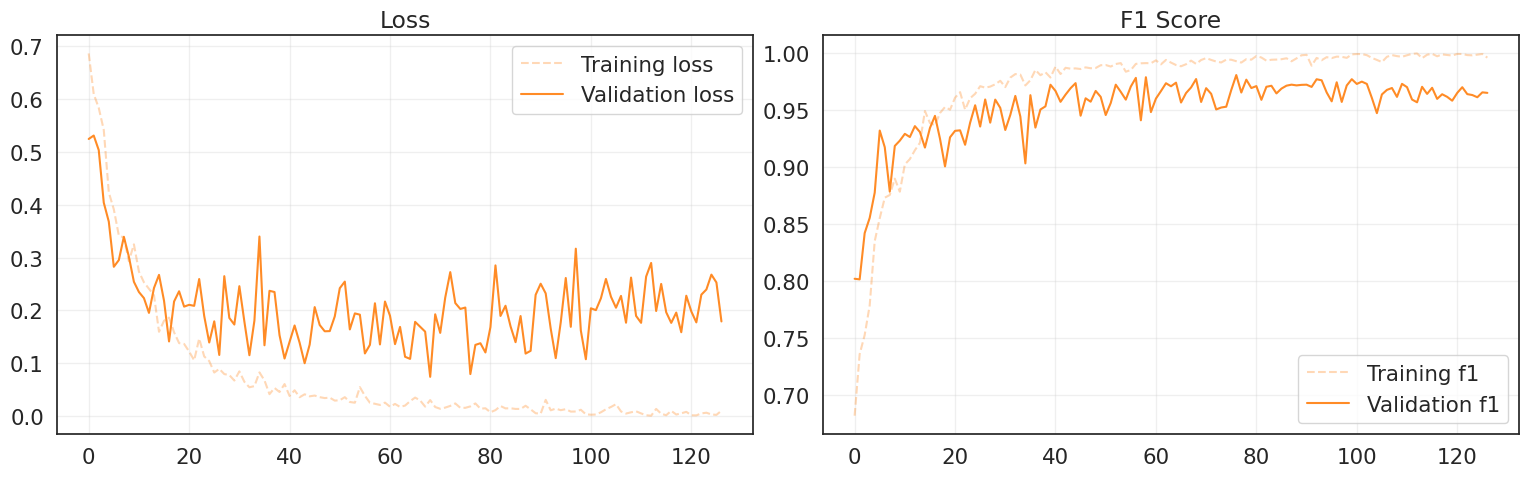

CPU times: user 2min 33s, sys: 16.3 s, total: 2min 49s
Wall time: 2min 47s


In [ ]:
%%time
# Train model and track training history
rnn_model, training_history = fit(
    model=rnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    writer=None,
    verbose=1,
    experiment_name="gru-bidirectional",
    patience=PATIENCE,
    gradient_clip=GRADIENT_CLIP
    )

# Update best model if current performance is superior
if training_history['val_f1'][-1] > best_performance:
    best_model = rnn_model
    best_performance = training_history['val_f1'][-1]

# Create a figure with two side-by-side subplots (two columns)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(training_history['train_loss'], label='Training loss', alpha=0.3, color='#ff7f0e', linestyle='--')
ax1.plot(training_history['val_loss'], label='Validation loss', alpha=0.9, color='#ff7f0e')
ax1.set_title('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation accuracy on the second axis
ax2.plot(training_history['train_f1'], label='Training f1', alpha=0.3, color='#ff7f0e', linestyle='--')
ax2.plot(training_history['val_f1'], label='Validation f1', alpha=0.9, color='#ff7f0e')
ax2.set_title('F1 Score')
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

Accuracy over the validation set: 0.9812
Precision over the validation set: 0.9813
Recall over the validation set: 0.9812
F1 score over the validation set: 0.9810


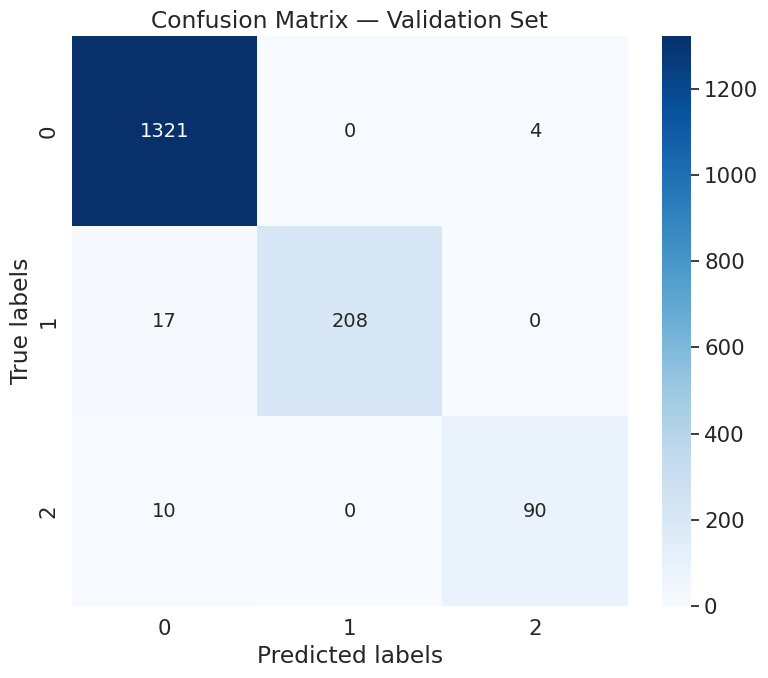

In [ ]:
# Plot Confusion Matrix
# Collect predictions and ground truth labels
val_preds, val_targets = [], []
with torch.no_grad():  # Disable gradient computation for inference
    for xb, yb in val_loader:
        xb = xb.to(device)

        # Forward pass: get model predictions
        logits = rnn_model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()

        # Store batch results
        val_preds.append(preds)
        val_targets.append(yb.numpy())

# Combine all batches into single arrays
val_preds = np.concatenate(val_preds)
val_targets = np.concatenate(val_targets)

# Calculate overall validation metrics
val_acc = accuracy_score(val_targets, val_preds)
val_prec = precision_score(val_targets, val_preds, average='weighted')
val_rec = recall_score(val_targets, val_preds, average='weighted')
val_f1 = f1_score(val_targets, val_preds, average='weighted')
print(f"Accuracy over the validation set: {val_acc:.4f}")
print(f"Precision over the validation set: {val_prec:.4f}")
print(f"Recall over the validation set: {val_rec:.4f}")
print(f"F1 score over the validation set: {val_f1:.4f}")

# Generate confusion matrix for detailed error analysis
cm = confusion_matrix(val_targets, val_preds)

# Create numeric labels for heatmap annotation
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Visualise confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=labels, fmt='',
            cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix — Validation Set')
plt.tight_layout()
plt.show()

## Submission

In [ ]:
# Load the actual test dataset (for submission)
if IN_COLAB:
    test_dataset = pd.read_csv('pirate_pain_test.csv')
else:
    test_dataset = pd.read_csv('dataset/pirate_pain_test.csv')

# Preprocess the test dataset (same as training data)
test_dataset['n_legs'] = preprocess_stringed_num(test_dataset['n_legs'])
test_dataset['n_hands'] = preprocess_stringed_num(test_dataset['n_hands'])
test_dataset['n_eyes'] = preprocess_stringed_num(test_dataset['n_eyes'])

# Normalize joint columns using the same min/max from training data
for column in joint_columns:
    if maxs[column] == mins[column]:
        test_dataset[column] = 0
    else:
        test_dataset[column] = (test_dataset[column] - mins[column]) / (maxs[column] - mins[column])

# Build sequences for test data (without labels)
def build_test_sequences(df, window=40, stride=5):
    """Build sequences from test data, grouped by sample_index"""
    sequences_by_sample = {}

    for sample_id in df['sample_index'].unique():
        cols = df.columns.difference(['sample_index', 'time'])
        temp = df[df['sample_index'] == sample_id][cols].values

        # Build overlapping windows for this sample
        sample_sequences = []
        idx = 0
        while idx + window <= len(temp):
            sample_sequences.append(temp[idx:idx + window])
            idx += stride

        sequences_by_sample[sample_id] = np.array(sample_sequences, dtype=np.float32)

    return sequences_by_sample

# Generate sequences for each sample
test_sequences = build_test_sequences(test_dataset, WINDOW_SIZE, STRIDE)

# Make predictions using the trained model
# Create reverse mapping from numeric labels to string labels
reverse_label_mapping = {v: k for k, v in label_mapping.items()}

predictions = []
rnn_model.eval()  # Set model to evaluation mode

with torch.no_grad():
    for sample_id in sorted(test_sequences.keys()):
        sequences = test_sequences[sample_id]

        # Convert to tensor and move to device
        sequences_tensor = torch.from_numpy(sequences).to(device)

        # Get predictions for all windows of this sample
        logits = rnn_model(sequences_tensor)
        window_predictions = logits.argmax(dim=1).cpu().numpy()

        # Aggregate predictions using majority voting
        from scipy import stats
        final_prediction = stats.mode(window_predictions, keepdims=False)[0]

        # Convert numeric prediction to string label
        label_str = reverse_label_mapping[final_prediction]

        predictions.append({
            'sample_index': sample_id,
            'label': label_str
        })

print(f"Generated predictions for {len(predictions)} samples")

submission_df = pd.DataFrame(predictions)
submission_df['sample_index'] = submission_df['sample_index'].apply(lambda x: f"{x:03d}")

# Sort by sample_index to ensure correct order
submission_df = submission_df.sort_values('sample_index').reset_index(drop=True)

# Save to CSV
submission_path = 'submission.csv'
submission_df.to_csv(submission_path, index=False)

print(f"Submission file saved to: {submission_path}")
print("Submission file preview:")
!head -25 submission.csv

Generated predictions for 1324 samples
Submission file saved to: submission.csv
Submission file preview:
sample_index,label
000,no_pain
001,no_pain
002,no_pain
003,no_pain
004,no_pain
005,no_pain
006,no_pain
007,no_pain
008,no_pain
009,no_pain
010,no_pain
011,no_pain
012,no_pain
013,no_pain
014,no_pain
015,no_pain
016,low_pain
017,no_pain
018,low_pain
019,no_pain
020,no_pain
021,no_pain
022,no_pain
023,low_pain
